In [1]:
# Entities
import numpy as np

from processing.robotics.arm_propagator import ArmPropagator, ElectromagnetEndEffector, RevoluteJoint
from processing.system_animation import animate_system
from processing.utilities.entities import Cylinder

# Attitude
from processing.attitude.attitude_propagator import AttitudePropagator
from processing.attitude.torques.base import TorqueObject
from processing.attitude.torques.eddy_current import EddyCurrentTorque

# Environment
from propagator.bin.environment import Environment

In [2]:
# Generate debris
debris = Cylinder(
    mass=950.0,
    radius=2.5,
    height=5.0,
    thickness=0.1,
    sigma=35000000.0
)

# Generate robotic arms (UR10 standard)
# Joints
joints = [
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(2.5, 0, 0),
    RevoluteJoint(0, 0.5, np.pi/2),
    RevoluteJoint(0, 0.25, -np.pi/2),
    RevoluteJoint(0, 0.25, 0)
]

# End effector
electromagnet: ElectromagnetEndEffector = ElectromagnetEndEffector(
    n_turns=500.0,
    radius=1.0,
    current=50.0
)

# External moments
# Eddy current
eddy: TorqueObject = EddyCurrentTorque(
    entity=debris,
    chaser_w0=[0.0, 0.0, 0.0],
    electromagnets=[electromagnet]
)

# Save attitude results
attitude = AttitudePropagator(entity=debris, M_ext=eddy)

# Save robotic arm results
base_offset = np.array([10, 0, 5])
max_torques = np.array([.05, .05, .05, .05, .05, .05])
arm = ArmPropagator(joints=joints, end_effector=electromagnet, base_offset=base_offset, max_torques=max_torques)

In [3]:
# Set propagation settings
t_step = .1  # Propagation time step [s]

# Set initial conditions
y0_arm = list(np.deg2rad(np.array([
    120, 50, 30, 0.0, 0.0, 0.0,   # Initial joint angles
    20, 0.0, 0.0, 0.0, 0.0, 0.0      # Initial joint velocities
])))
y0_debris = [
    0.1, 0.2, 0.0,                    # Initial debris angular velocity
    0.0, 0.0, 0.0, 1.0                # Initial debris quaternions
]   

# Initialize environment
env = Environment(
    y0_arm + y0_debris,                   # Initial conditions
    debris.Ixx,                           # Debris Ixx
    debris.Iyy,                           # Debris Iyy
    debris.Izz,                           # Debris Izz
    debris.radius,                        # Debris cylinder radius
    debris.height,                        # Debris cylinder height 
    debris.thickness,                     # Debris cylinder thickness
    debris.sigma,                         # Debris conductivity
    electromagnet.n_turns,                # Coil number of turns
    electromagnet.current,                # Coil current
    electromagnet.radius,                 # Coil radius
    arm.base_offset_x,                    # Arm base x-offset
    arm.base_offset_y,                    # Arm base y-offset
    arm.base_offset_z,                    # Arm base z-offset
    arm.dh_a,                             # Arm joint a parameters
    arm.dh_d,                             # Arm joint d parameters
    arm.dh_alpha,                         # Arm joint alpha parameters
    arm.max_torques                       # Arm joint max torques
    )

## Save initial conditions

In [4]:
def save(tf, prop):
    # to numpy
    prop = np.array(prop)
    
    # save
    arm.save_new(tf, prop=prop)
    attitude.save_new(tf, prop=prop)
    
# Get initial state
t, s = env.current_state()
save(t, s)

## Loop

In [5]:
# Set desired position
yD_arm = list(np.deg2rad(np.array([
    180.0, -20.0, 0.0, 0.0, 0.0, 0.0,     # Desired joint angles
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0      # Desired joint velocities
])))

# Set control parameters
env.set_control_torque(yD=yD_arm)

# Perform steps
while t < 40:
    # Perform step
    t, s = env.step(t_step=t_step)
    save(t, s)
    

At (0) t = 1.0000e-01    y =  2.129412e+00    8.724151e-01    5.234918e-01   -1.307533e-18    3.880652e-18    1.189618e-18    3.512534e-01
At (1) t = 2.0000e-01    y =  2.164641e+00    8.716685e-01    5.231719e-01    1.243717e-18    9.848294e-19   -2.437469e-19    3.532858e-01
At (2) t = 3.0000e-01    y =  2.200064e+00    8.704276e-01    5.226400e-01    4.948469e-17   -9.577477e-17   -4.962291e-17    3.551637e-01
At (3) t = 4.0000e-01    y =  2.235668e+00    8.686953e-01    5.218977e-01    1.910097e-16   -3.840978e-16   -1.997460e-16    3.568877e-01
At (4) t = 5.0000e-01    y =  2.271437e+00    8.664746e-01    5.209459e-01    4.813639e-16   -9.772244e-16   -5.110535e-16    3.584583e-01
At (5) t = 6.0000e-01    y =  2.307355e+00    8.637681e-01    5.197860e-01    1.057818e-15   -2.147977e-15   -1.123631e-15    3.598756e-01
At (6) t = 7.0000e-01    y =  2.343407e+00    8.605789e-01    5.184192e-01    2.035317e-15   -4.125582e-15   -2.155808e-15    3.611400e-01
At (7) t = 8.0000e-01    y 

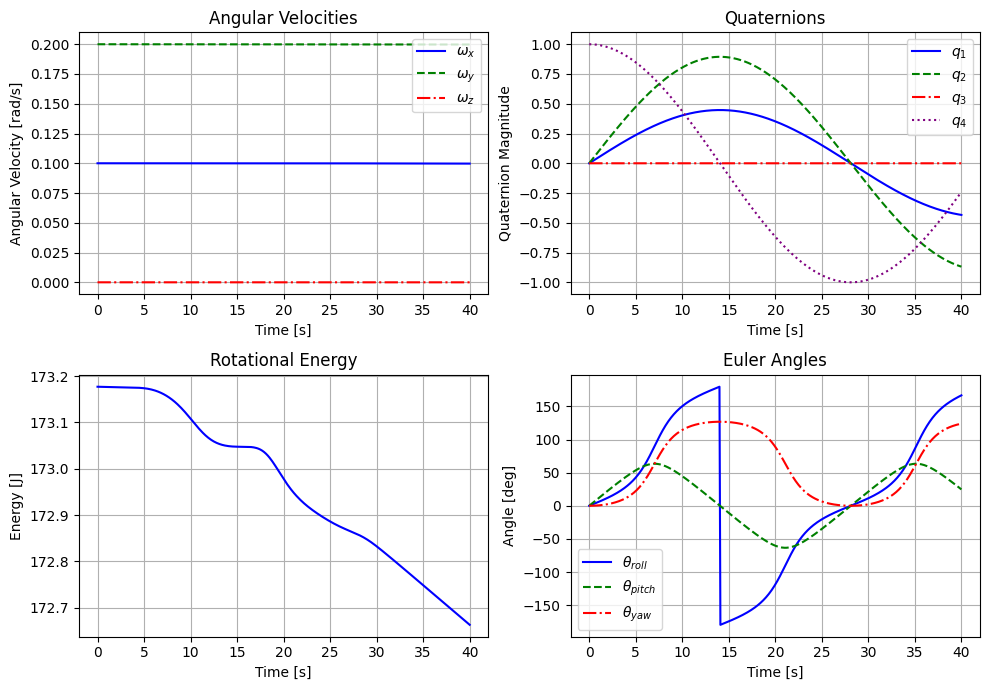

In [6]:
attitude.plot(["angular_velocity", "quaternions", "energy", "euler_angles"])

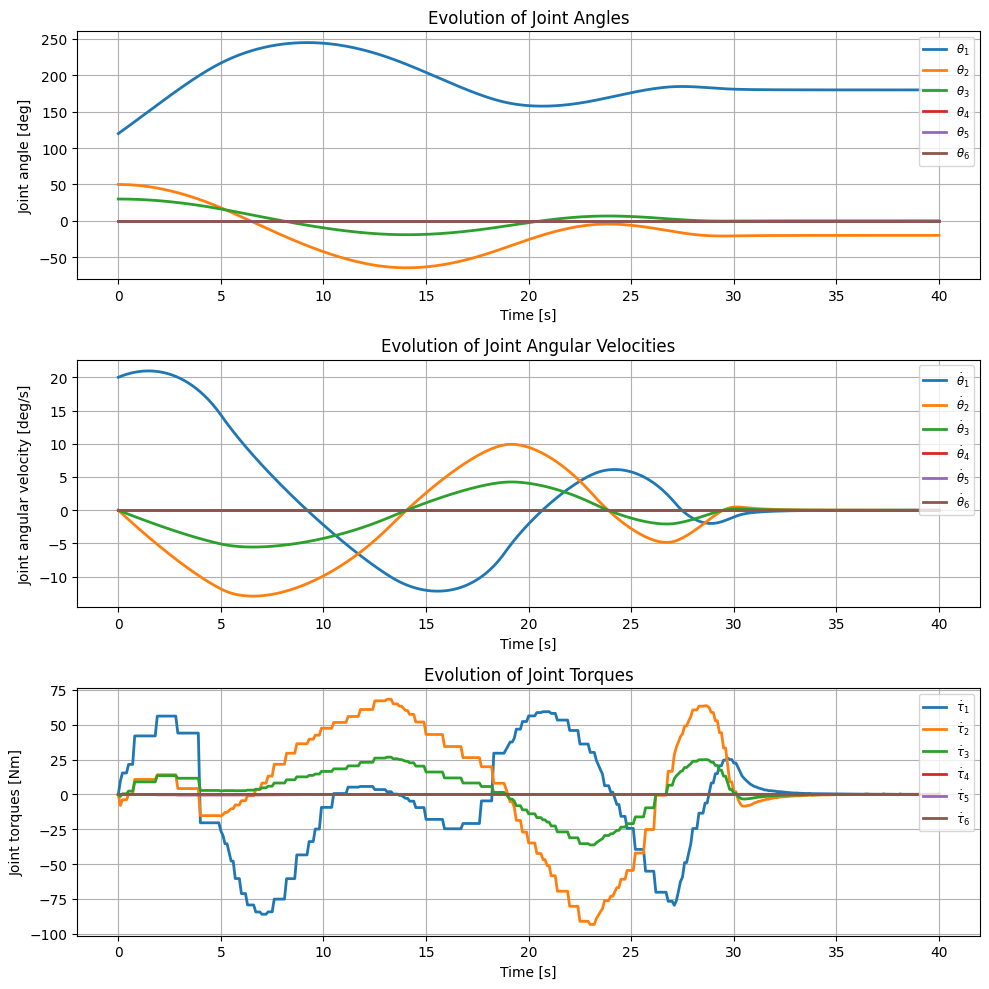

In [7]:
arm.plot()

- Animation rendering progress -
[=====================]  100.00% (401/401) ETA: 0m 0s


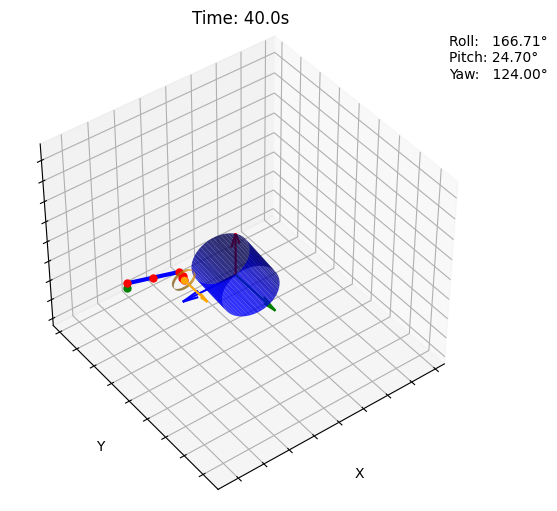

In [8]:
animate_system(
    t=attitude.t,
    q=attitude.q,
    eu=attitude.euler_angles,
    h=debris.height,
    r=debris.radius,
    dpi=300,
    arms=[arm],
    dh_par=joints
)